# CHE1147H A5 - Supervised learning
 
    Classication problem: predict the clients response (0 for clients who responded negatively to the promotional campaign and 1 for 
    clients who responded positively to the campaign. The clients responses are stored in the Retail_Data_Response.csv from Kaggle.  
    
    ✓ Features: annual and monthly 
    ✓ Algorithms: Logistic Regression with L1 regularization, Decision Tree, Random Forests



##### Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

import imblearn
from imblearn.over_sampling import RandomOverSampler 
 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1.1 Import the monthly and annual data and join
    Create the joined tables. 
    ✓ annual_features_outputs: annual_features.xlsx, annual_day_of_week_counts_pivot.xlsx
    ✓ monthly_features_outputs: mth_rolling_features.xlsx, mth_day_counts.xlsx, days_since_last_txn.xlsx
    ✓ Join Retail_Data_Response.csv at the end for both. This is simply a table that contains the binary response of the client to our 
    marketing effort and that is the output/label/target that makes this a supervised learning problem.

In [2]:
# Table 'annual_features_outputs'

# Import files
annual_features = pd.read_excel("annual_features.xlsx")
print('Demension of annual_features:',annual_features.shape)

annual_day_of_week_counts_pivot = pd.read_excel("annual_day_of_week_counts_pivot.xlsx")
print('Demension of annual_day_of_week_counts_pivot:',annual_day_of_week_counts_pivot.shape)

Retail_Data_Response = pd.read_csv("Retail_Data_Response.csv")
print('Demension of Retail_Data_Response:',Retail_Data_Response.shape,'\n')

# Merge files on 'customer_id' 
# No response for 5 customers ['CS7297', 'CS7413', 'CS7638', 'CS8376', 'CS8753']
print ('No response for customers:',[i for i in list(annual_features.customer_id) if not i in list(Retail_Data_Response.customer_id) ])

annual_features_outputs = pd.merge(annual_features, annual_day_of_week_counts_pivot ,on='customer_id')
annual_features_outputs = pd.merge(Retail_Data_Response, annual_features_outputs ,on='customer_id')
print('Demension of annual_features_outputs:',annual_features_outputs.shape,'\n')
print ("Check if the number of columns correct:", annual_features_outputs.shape[1] == (annual_features.shape[1] + 
                                                                                      annual_day_of_week_counts_pivot.shape[1]) +
                                                                                      Retail_Data_Response.shape[1] -2)
annual_features_outputs

Demension of annual_features: (6889, 41)
Demension of annual_day_of_week_counts_pivot: (6889, 36)
Demension of Retail_Data_Response: (6884, 2) 

No response for customers: ['CS7297', 'CS7413', 'CS7638', 'CS8376', 'CS8753']
Demension of annual_features_outputs: (6884, 77) 

Check if the number of columns correct: True


,customer_id,response,ann_txn_amt_ave_2011,ann_txn_amt_ave_2012,ann_txn_amt_ave_2013,ann_txn_amt_ave_2014,ann_txn_amt_ave_2015,ann_txn_amt_cnt_2011,ann_txn_amt_cnt_2012,ann_txn_amt_cnt_2013,ann_txn_amt_cnt_2014,ann_txn_amt_cnt_2015,ann_txn_amt_max_2011,ann_txn_amt_max_2012,ann_txn_amt_max_2013,ann_txn_amt_max_2014,ann_txn_amt_max_2015,ann_txn_amt_min_2011,ann_txn_amt_min_2012,ann_txn_amt_min_2013,ann_txn_amt_min_2014,ann_txn_amt_min_2015,ann_txn_amt_sem_2011,ann_txn_amt_sem_2012,ann_txn_amt_sem_2013,ann_txn_amt_sem_2014,ann_txn_amt_sem_2015,ann_txn_amt_std_2011,ann_txn_amt_std_2012,ann_txn_amt_std_2013,ann_txn_amt_std_2014,ann_txn_amt_std_2015,ann_txn_amt_sum_2011,ann_txn_amt_sum_2012,ann_txn_amt_sum_2013,ann_txn_amt_sum_2014,ann_txn_amt_sum_2015,ann_txn_amt_var_2011,ann_txn_amt_var_2012,ann_txn_amt_var_2013,ann_txn_amt_var_2014,ann_txn_amt_var_2015,cnt_2011_Friday,cnt_2011_Monday,cnt_2011_Saturday,cnt_2011_Sunday,cnt_2011_Thursday,cnt_2011_Tuesday,cnt_2011_Wednesday,cnt_2012_Friday,cnt_2012_Monday,cnt_2012_Saturday,cnt_2012_Sunday,cnt_2012_Thursday,cnt_2012_Tuesday,cnt_2012_Wednesday,cnt_2013_Friday,cnt_2013_Monday,cnt_2013_Saturday,cnt_2013_Sunday,cnt_2013_Thursday,cnt_2013_Tuesday,cnt_2013_Wednesday,cnt_2014_Friday,cnt_2014_Monday,cnt_2014_Saturday,cnt_2014_Sunday,cnt_2014_Thursday,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday
0,CS1112,0,70.666667,67.400000,70.666667,70.666667,39.000000,3,5,3,3,1,96,81,105,90,39,56,52,36,59,39,12.719189,5.688585,19.919282,9.735388,0.000000,22.030282,12.720063,34.501208,16.862186,0.000000,212,337,212,212,39,485.333333,161.800000,1190.333333,284.333333,0.000000,1,0,0,1,0,0,1,0,0,1,3,0,1,0,1,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1
1,CS1113,0,81.333333,74.800000,85.200000,56.500000,73.333333,3,5,5,4,3,94,95,97,97,98,57,51,65,36,44,12.170091,7.618399,5.851496,13.979151,15.762121,21.079216,17.035258,13.084342,27.958302,27.300794,244,374,426,226,220,444.333333,290.200000,171.200000,781.666667,745.333333,1,1,0,1,0,0,0,2,1,0,0,0,1,1,0,1,1,0,0,2,1,0,0,1,0,0,3,0,0,2,0,0,0,0,1
2,CS1114,1,85.200000,75.000000,70.400000,70.833333,79.000000,5,2,5,6,1,97,97,105,95,79,76,53,43,37,79,4.352011,22.000000,11.129241,11.001263,0.000000,9.731393,31.112698,24.885739,26.947480,0.000000,426,150,352,425,79,94.700000,968.000000,619.300000,726.166667,0.000000,0,1,0,1,1,0,2,0,0,1,1,0,0,0,0,1,0,1,2,0,1,1,1,1,1,0,1,1,0,0,0,0,1,0,0
3,CS1115,1,87.000000,67.571429,79.571429,78.250000,55.000000,3,7,7,4,1,102,104,94,98,55,72,41,66,50,55,8.660254,8.257341,3.981249,11.316470,0.000000,15.000000,21.846870,10.533394,22.632941,0.000000,261,473,557,313,55,225.000000,477.285714,110.952381,512.250000,0.000000,0,0,1,1,0,0,1,1,1,0,2,1,1,1,0,1,2,0,2,0,2,0,0,0,0,2,0,2,0,0,0,0,1,0,0
4,CS1116,1,58.750000,76.666667,59.000000,66.600000,0.000000,4,3,1,5,0,87,105,59,96,0,41,45,59,40,0,10.601690,17.400511,0.000000,11.285389,0.000000,21.203380,30.138569,0.000000,25.234896,0.000000,235,230,59,333,0,449.583333,908.333333,0.000000,636.800000,0.000000,1,1,0,0,1,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,3,1,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6879,CS8996,0,31.000000,33.666667,41.500000,56.000000,0.000000,2,3,2,6,0,38,38,50,79,0,24,29,33,30,0,7.000000,2.603417,8.500000,8.959167,0.000000,9.899495,4.509250,12.020815,21.945387,0.000000,62,101,83,336,0,98.000000,20.333333,144.500000,481.600000,0.000000,0,1,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,1,1,2,0,0,0,0,0,0,0
6880,CS8997,0,45.000000,39.500000,35.166667,42.000000,0.000000,2,4,6,2,0,47,49,75,45,0,43,33,21,39,0,2.000000,3.378856,8.576777,3.000000,0.000000,2.828427,6.757712,21.008728,4.242641,0.000000,90,158,

In [3]:
print ('annual_features_outputs is clean:', sum(annual_features_outputs.isnull().sum())==0)

annual_features_outputs is clean: True


In [4]:
# Table 'monthly_features_outputs'

# Import files
mth_rolling_features = pd.read_excel("mth_rolling_features.xlsx")
mth_rolling_features = mth_rolling_features.drop(mth_rolling_features.columns[0], axis=1)
# fill nan with 0
mth_rolling_features = mth_rolling_features.fillna(0)
print('Demension of mth_rolling features:',mth_rolling_features.shape)

mth_day_counts = pd.read_excel("mth_day_counts.xlsx")
mth_day_counts = mth_day_counts.drop(mth_day_counts.columns[0], axis=1)
print('Demension of annual_day_of_week_counts_pivot:',mth_day_counts.shape)

days_since_last_txn = pd.read_excel("days_since_last_txn.xlsx")
days_since_last_txn = days_since_last_txn.drop(days_since_last_txn.columns[0], axis=1)
print('Demension of days_since_last_txn:',days_since_last_txn.shape,'\n')

Retail_Data_Response = Retail_Data_Response.rename(columns={'customer_id': 'CLNT_NO'}) 

# Merge files on ['CLNT_NO','ME_DT']

monthly_features_outputs = pd.merge(mth_rolling_features, mth_day_counts ,on=['CLNT_NO','ME_DT'])
monthly_features_outputs = pd.merge(monthly_features_outputs, days_since_last_txn, on=['CLNT_NO','ME_DT'])

# Merge files on 'ME_DT'
monthly_features_outputs = pd.merge(Retail_Data_Response, monthly_features_outputs, on=['CLNT_NO'])
print('Demension of monthly_features_outputs:',monthly_features_outputs.shape)

print ("Check if the number of columns correct:", 
       monthly_features_outputs.shape[1] == (mth_rolling_features .shape[1] + mth_day_counts.shape[1] + days_since_last_txn.shape[1] 
       + Retail_Data_Response.shape[1] - 5))

monthly_features_outputs 

Demension of mth_rolling features: (323783, 22)
Demension of annual_day_of_week_counts_pivot: (323783, 9)
Demension of days_since_last_txn: (323783, 3) 

Demension of monthly_features_outputs: (323548, 31)
Check if the number of columns correct: True


,CLNT_NO,response,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,amt_sum_6M,amt_mean_6M,amt_max_6M,txn_cnt_sum_6M,txn_cnt_mean_6M,txn_cnt_max_6M,amt_sum_12M,amt_mean_12M,amt_max_12M,txn_cnt_sum_12M,txn_cnt_mean_12M,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn
0,CS1112,0,2011-05-31,0,0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0,0,0,0,0,0,0,-10
1,CS1112,0,2011-06-30,56,1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0,0,0,0,0,0,1,15
2,CS1112,0,2011-07-31,0,0,56.0,56.0,18.666667,1.0,1.0,0.333333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0,0,0,0,0,0,0,46
3,CS1112,0,2011-08-31,96,1,96.0,152.0,50.666667,1.0,2.0,0.666667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,1,0,0,0,0,0,0,12
4,CS1112,0,2011-09-30,0,0,96.0,96.0,32.000000,1.0,1.0,0.333333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0,0,0,0,0,0,0,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323543,CS9000,0,2014-11-30,0,0,0.0,0.0,0.000000,0.0,0.0,0.000000,35.0,61.0,10.166667,1.0,2.0,0.333333,35.0,97.0,8.083333,1.0,4.0,0.333333,0,0,0,0,0,0,0,98
323544,CS9000,0,2014-12-31,0,0,0.0,0.0,0.000000,0.0,0.0,0.000000,35.0,61.0,10.166667,1.0,2.0,0.333333,35.0,97.0,8.083333,1.0,4.0,0.333333,0,0,0,0,0,0,0,129
323545,CS9000,0,2015-01-31,0,0,0.0,0.0,0.000000,0.0,0.0,0.000000,35.0,35.0,5.833333,1.0,1.0,0.166667,35.0,81.0,6.750000,1.0,3.0,0.250000,0,0,0,0,0,0,0,160
323546,CS9000,0,2015-02-28,34,1,34.0,34.0,11.333333,1.0,1.0,0.333333,34.0,34.0,5.666667,1.0,1.0,0.166667,35.0,115.0,9.583333,1.0,4.0,0.333333,0,0,1,0,0,0,0,0


In [5]:
print ('monthly_features_outputs is clean:', sum(monthly_features_outputs.isnull().sum())==0)

monthly_features_outputs is clean: True


## 1.2 Steps for each method
    1. Separate the inputs X and the output y in two data frames.
    ✓ For annual feattures: random oversample minority class on training data

    2. Split the data in train and test set. Use a test size value of 2/3 and set the random state equal to 1147 for consistency 
    Use the following names for consistency:
|        |   |  |   |
| ------------- | ------------- | ------------- | ------------- |
| Annual       |X_train_annual| y_train_annual| X_test_annual| y_test_annual |
| Monthly      | X_train_monthl| y_train_monthly| X_test_monthly|y_test_monthly|

    3. Pre-process (if necessary for the method).
    4. Fit the training dataset and optimize the hyperparameters of the method.
    5. Plot coeffcient values or feature importance.
    6. Plot probability distribution for test set.
    7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.
    8. Plot decision boundary for top 2 features.


### Annual Features  

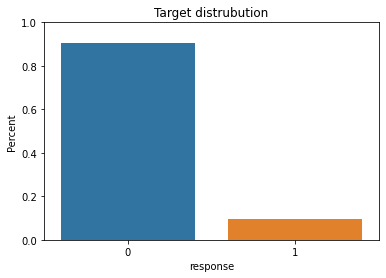

In [6]:
# Data overview (unbalance)

sns.barplot(x="response", y="response", data=annual_features_outputs, estimator=lambda x: len(x) / len(annual_features_outputs))
plt.ylabel("Percent")
plt.title('Target distrubution')
plt.ylim(0,1)
plt.show()

In [170]:
# 1. Separate the inputs X and the output y  
X_annual = annual_features_outputs.drop(['response','customer_id'],1)
y_annual = annual_features_outputs.response

unique_elements, counts_elements = np.unique(y_annual, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   0    1]
 [6237  647]]


In [171]:
# 2. Split the data in train and test set. 
X_train_annual, X_test_annual, y_train_annual, y_test_annual = train_test_split(X_annual, y_annual, test_size=2/3, random_state=1147)

unique_elements, counts_elements = np.unique(y_train_annual, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   0    1]
 [2098  196]]


In [172]:
# Random over sample minority class on training data
ros = RandomOverSampler(sampling_strategy=0.4,random_state=1147)
X_train_annual, y_train_annual = ros.fit_sample(X_train_annual, y_train_annual)

unique_elements, counts_elements = np.unique(y_train_annual, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   0    1]
 [2098  839]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [173]:
# 3. Pre-process data (standardized)
scaler = StandardScaler()
X_train_annual = scaler.fit_transform(X_train_annual)
X_test_annual = scaler.transform(X_test_annual)

#### 1. Logistic Regression with L1 regularization
    Based on this question relate to promotional campaign, compare to miss  client respond positively, promote to client who respond 
    negatively is more accepted. Try different metric, aim to find one min FN.
    Based on results, adopt oversample strategy. The strategy don't vary too much, maybe due to small amount of tuning hyperparameters. 
    Choose f1 when dataset is inbalanced, which consider both precision and recall.   

| | Metric       | C | Accuracy | FN |
| ------- | ------------- | ------------- | ------------- | ------------- |
|Oversample| recall        | 100           | 0.8277        | 323 |
| | accuracy       | 100           | 0.8277        | 323 |
| | f1  | 100           | 0.8277        | 323 |
| | roc_auc  | 1|0.8342| 327|
| |        |   | |
|Regular| recall        |  1000|0.8969 |438|
| | accuracy       | 0.01|0.9017|451| 
| | f1  |  1000|0.8969 |438|
| | roc_auc  | 0.1| 0.8993|447|

    Rry to lower treshhold for classification. We could achieve recall of 1 by estimating all data as positively responded clients, but 
    this is not what we want. We could examine the accracy to make sure it's not too low.
    Set treshhold = 0.45. We would miss some positive clients, but the accuacy is remain above 80%.
|Oversample,f1,C=100| Treshhold       | Accuracy | FN |
| ------- | ------------- | ------------- | ------------- | 
| | 0.5     | 0.8277        | 323 |
| | 0.45         | 0.8126 | 290 |
| | 0.4  |0.7887| 259|

In [174]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
lr = LogisticRegression(penalty ='l1', solver = 'liblinear', random_state=1147)

# Gridsearch best hyperparameters using mereic 'roc_auc'
grid = GridSearchCV(lr, {'C':[0.01, 0.1, 1, 10, 100,1000]}, scoring='f1', cv=10, n_jobs=-1)
grid.fit(X_train_annual, y_train_annual)
best_hyper = grid.best_params_
print ("Best f1: {}".format(grid.best_score_))      
print('The best parameter:', best_hyper)

# fit model on the training dataset
lr = LogisticRegression(C=best_hyper['C'], penalty ='l1', solver = 'liblinear', random_state=1147)
# lr = LogisticRegression(C=1, penalty ='l1', solver = 'liblinear', random_state=1147)

lr.fit(X_train_annual, y_train_annual)

Best f1: 0.546774502159729
The best parameter: {'C': 100}


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=1147, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

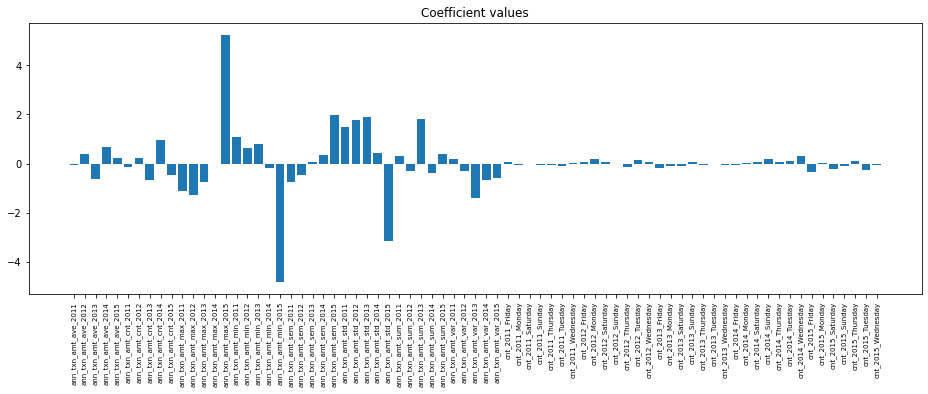

In [175]:
# 5. Plot coeffcient values or feature importance.
coeffcient = lr.coef_

plt.figure(figsize=(16,5))
plt.bar(range(X_annual.shape[1]), coeffcient[0])
plt.title("Coefficient values")
plt.xticks(range(X_annual.shape[1]), X_annual.columns, rotation=90,size=7)
plt.show()

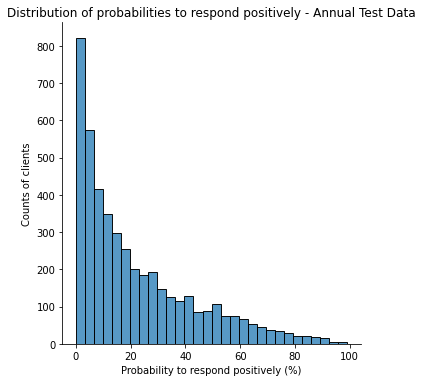

In [176]:
# 6. Plot probability distribution for test set
y_test_proba = lr.predict_proba(X_test_annual)
sns.displot(data = y_test_proba[:,1], x = 100 * y_test_proba[:,1])
plt.title('Distribution of probabilities to respond positively - Annual Test Data')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.show()

In [177]:
# 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

Test Accuracy: 0.8126361655773421


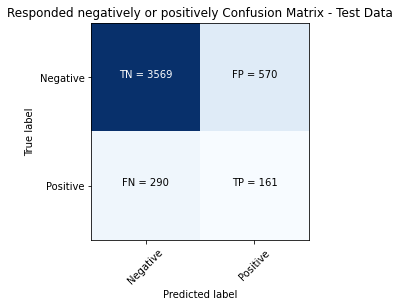



 Train Accuracy: 0.780388151174668


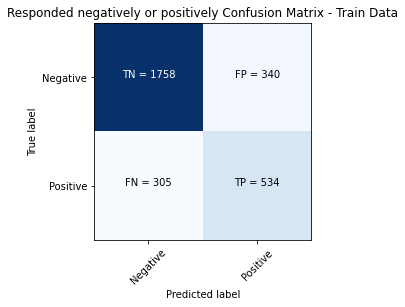

In [178]:
# Confusion matrix - Test Data

# y_test_predicted = lr.predict (X_test_annual)
# cm = confusion_matrix(y_test_annual, y_test_predicted)

y_test_proba = lr.predict_proba(X_test_annual)
y_test_predicted = [1 if x >= 0.45 else 0 for x in y_test_proba[:,1]] # lower treshhold for classification
print ('Test Accuracy:',accuracy_score(y_test_annual, y_test_predicted))
cm = confusion_matrix(y_test_annual, y_test_predicted)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
plt.show()

# Confusion matrix - Train Data
y_train_proba = lr.predict_proba(X_train_annual)
y_train_predicted = [1 if x >= 0.40 else 0 for x in y_train_proba[:,1]] # lower treshhold for classification
print ('\n\n Train Accuracy:',accuracy_score(y_train_annual, y_train_predicted))
cm = confusion_matrix(y_train_annual, y_train_predicted)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

plt.show()

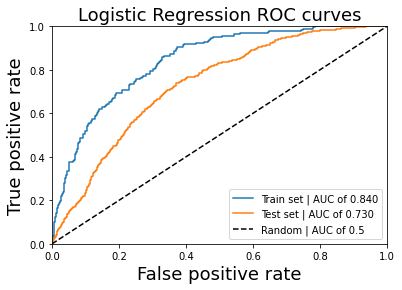

In [179]:
# ROC curves - Train set
scores_train = lr.predict_proba(X_train_annual)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
auc_train = auc(fpr_train, tpr_train)

# ROC curves - Test Data
scores_test = lr.predict_proba(X_test_annual)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Logistic Regression ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

In [17]:
# precision/recall
print(classification_report(y_test_annual, y_test_predicted, target_names = ['Negative(0)', 'Positive(1)']))

              precision    recall  f1-score   support

 Negative(0)       0.92      0.86      0.89      4139
 Positive(1)       0.22      0.36      0.27       451

    accuracy                           0.81      4590
   macro avg       0.57      0.61      0.58      4590
weighted avg       0.86      0.81      0.83      4590



In [18]:
# 8. Plot decision boundary for top 2 features.

min_list = X_train_annual.min(axis=0) 
max_list = X_train_annual.max(axis=0)

# top feature index
top_feature1_index = list(coeffcient[0]).index(np.sort(coeffcient[0])[-1])
top_feature2_index = list(coeffcient[0]).index(np.sort(coeffcient[0])[-2])

# top feature
top_feature1 = X_annual.columns[top_feature1_index]
top_feature2 = X_annual.columns[top_feature2_index]

# min/max 
top_feature1_min= min_list[top_feature1_index]
top_feature1_max= max_list[top_feature1_index]
top_feature2_min= min_list[top_feature2_index]
top_feature2_max= max_list[top_feature2_index]

print ('1st top feature {}, min={}, max={}'.format(top_feature1,top_feature1_min,top_feature1_max))
print ('2nd top feature {}, min={}, max={}'.format(top_feature2,top_feature2_min,top_feature2_max))

1st top feature ann_txn_amt_max_2015, min=-1.0902166892370504, max=1.6067709067068592
2nd top feature ann_txn_amt_sem_2015, min=-0.4645275079510679, max=5.5050865282366095


In [19]:
xx, yy = np.mgrid[-2.1:2.1, -1.1:6.1]
grid = np.c_[xx.ravel(), yy.ravel()]
print ('grid dimenshion:',grid.shape) # Confirm grid shape  

grid dimenshion: (40, 2)


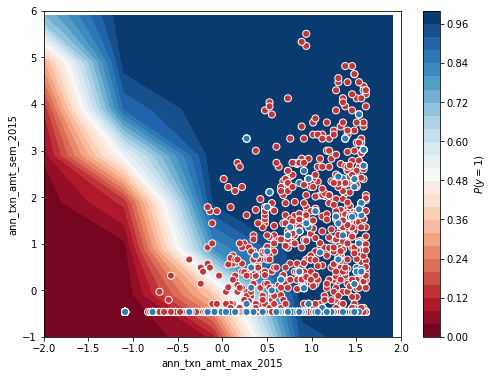

In [20]:
# calculates the median of every column  
median_inputs = np.ones((grid.shape[0], X_train_annual.shape[1])) * np.median(X_train_annual, axis=0) 

# replace the column of top 2 features with the values of the grid
median_inputs[:,top_feature1_index] = grid[:,0]
median_inputs[:,top_feature2_index] = grid[:,1]
 
# compute probability of respende positively
probs = lr.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

# plot decision boundary
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
# ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_annual[50:,top_feature1_index], X_train_annual[50:, top_feature2_index], c=y_train_annual[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="auto",
       xlim=(-2, 2), ylim=(-1, 6),
       xlabel=str(top_feature1), ylabel=str(top_feature2))
plt.show()

#### 2. Decision Tree

In [36]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
tree = DecisionTreeClassifier(criterion = 'gini', random_state=1147, max_depth = 10, ccp_alpha = 0.004)

# Gridsearch best hyperparameters using mereic 'roc_auc'
grid = GridSearchCV(tree, {'min_samples_split':[1,20,50,100,500]}, scoring='f1', cv=10, n_jobs=-1)
grid.fit(X_train_annual, y_train_annual)
best_hyper = grid.best_params_
print ("Best f1: {}".format(grid.best_score_))      
print('The best parameter:', best_hyper)

# fit model on the training dataset
tree = DecisionTreeClassifier(min_samples_split=best_hyper['min_samples_split'],
                              criterion = 'gini', random_state=1147, max_depth = 10,ccp_alpha = 0.004)
tree.fit(X_train_annual, y_train_annual)

Best f1: 0.6116540242169713
The best parameter: {'min_samples_split': 20}


DecisionTreeClassifier(ccp_alpha=0.004, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1147, splitter='best')

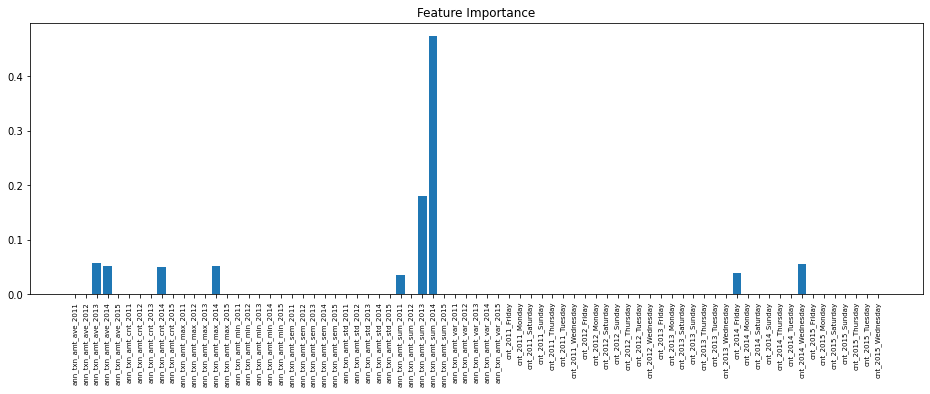

In [37]:
# 5. Plot coeffcient values or feature importance. 
importances = tree.feature_importances_

plt.figure(figsize=(16,5))
plt.bar(range(X_annual.shape[1]), importances)
plt.title("Feature Importance")
plt.xticks(range(X_annual.shape[1]), X_annual.columns, rotation=90,size=7)
plt.show()

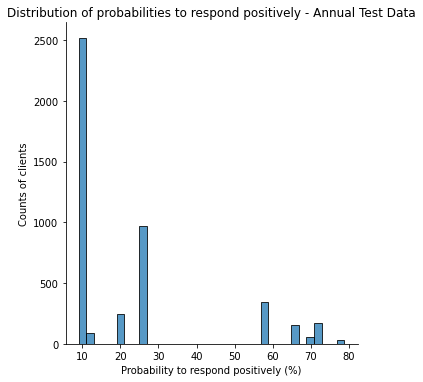

In [38]:
# 6. Plot probability distribution for test set
y_test_proba = tree.predict_proba(X_test_annual)
sns.displot(data = y_test_proba[:,1], x = 100*y_test_proba[:,1])
plt.title('Distribution of probabilities to respond positively - Annual Test Data')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.show()

In [39]:
# How many different probabilities of respond positively are there and how many clients in each?
unique_elements, counts_elements = np.unique(y_test_proba[:,1], return_counts=True)
print("Frequency of unique values of the said array:")
print(unique_elements)
print(counts_elements)

Frequency of unique values of the said array:
[0.09084195 0.12765957 0.19148936 0.19767442 0.25651303 0.26436782
 0.57777778 0.65680473 0.68918919 0.72123894 0.78787879]
[2521   91   97  146  826  146  345  153   60  173   32]


In [ ]:
# 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

Test Accuracy: 0.8008714596949891


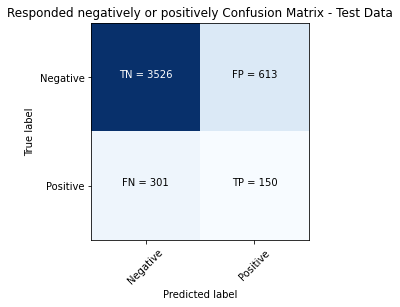



 Train Accuracy: 0.7991147429349676


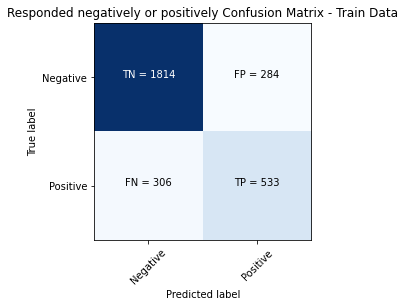

In [40]:
# Confusion matrix - Test Data

y_test_predicted = tree.predict (X_test_annual)
cm = confusion_matrix(y_test_annual, y_test_predicted)
print ('Test Accuracy:',accuracy_score(y_test_annual, y_test_predicted))
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
plt.show()

# Confusion matrix - Train Data

y_train_proba = tree.predict_proba(X_train_annual)
y_train_predicted = [1 if x >= 0.40 else 0 for x in y_train_proba[:,1]] # lower treshhold for classification
print ('\n\n Train Accuracy:',accuracy_score(y_train_annual, y_train_predicted))
cm = confusion_matrix(y_train_annual, y_train_predicted)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

plt.show() 

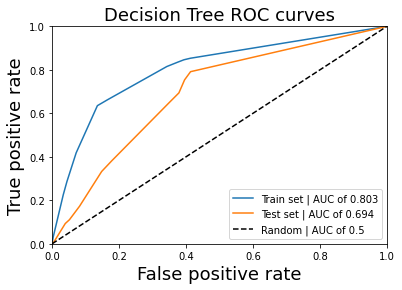

In [41]:
# ROC curves - Train set
scores_train = tree.predict_proba(X_train_annual)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
auc_train = auc(fpr_train, tpr_train)

# ROC curves - Test Data
scores_test = tree.predict_proba(X_test_annual)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Decision Tree ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

In [42]:
# precision/recall
print(classification_report(y_test_annual, y_test_predicted, target_names = ['Negative(0)', 'Positive(1)']))

              precision    recall  f1-score   support

 Negative(0)       0.92      0.85      0.89      4139
 Positive(1)       0.20      0.33      0.25       451

    accuracy                           0.80      4590
   macro avg       0.56      0.59      0.57      4590
weighted avg       0.85      0.80      0.82      4590



In [43]:
# 8. Plot decision boundary for top 2 features.

min_list = X_train_annual.min(axis=0) 
max_list = X_train_annual.max(axis=0)

# top feature index
top_feature1_index = list(importances).index(np.sort(importances)[-1])
top_feature2_index = list(importances).index(np.sort(importances)[-2])

# top feature
top_feature1 = X_annual.columns[top_feature1_index]
top_feature2 = X_annual.columns[top_feature2_index]

# min/max 
top_feature1_min= min_list[top_feature1_index]
top_feature1_max= max_list[top_feature1_index]
top_feature2_min= min_list[top_feature2_index]
top_feature2_max= max_list[top_feature2_index]

print ('1st top feature {}, min={}, max={}'.format(top_feature1,top_feature1_min,top_feature1_max))
print ('2nd top feature {}, min={}, max={}'.format(top_feature2,top_feature2_min,top_feature2_max))

1st top feature ann_txn_amt_sum_2014, min=-1.8280677621886374, max=3.414767789738315
2nd top feature ann_txn_amt_sum_2013, min=-1.749688568792104, max=5.112171906638118


In [44]:
xx, yy = np.mgrid[-2.1:4.1, -2.1:6.1]
grid = np.c_[xx.ravel(), yy.ravel()]
print ('grid dimenshion:',grid.shape) # Confirm grid shape  
# calculates the median of every column  
median_inputs = np.ones((grid.shape[0], X_train_annual.shape[1])) * np.median(X_train_annual, axis=0) 

# replace the column of top 2 features with the values of the grid
median_inputs[:,top_feature1_index] = grid[:,0]
median_inputs[:,top_feature2_index] = grid[:,1]
 
# compute probability of respende positively
probs = tree.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

grid dimenshion: (63, 2)


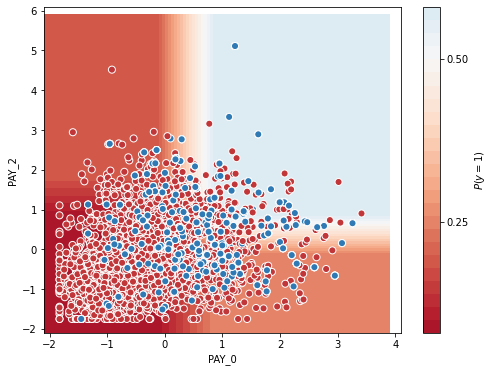

In [45]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_annual[50:,top_feature1_index], X_train_annual[50:,top_feature2_index], c=y_train_annual[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
# plt.annotate('Node #6 \n P(default) = 69.9%', xy=(5,1), xycoords='data',horizontalalignment= 'center', fontsize = 14)
# plt.annotate('Node #2 \n P = 15.0%', xy=(-0.5,0.5), xycoords='data',horizontalalignment= 'center', fontsize = 14)
# plt.annotate('Node #5 \n P = 43.1%', xy=(-0.5,6.0), xycoords='data',horizontalalignment= 'center', fontsize = 14)

ax.set(aspect="auto",
       xlim=(-2.1, 4.1), ylim=(-2.1, 6.1),
       xlabel="PAY_0", ylabel="PAY_2")
plt.show()

#### 3. Random Forests

In [180]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
forest = RandomForestClassifier(n_estimators = 200, criterion = 'gini',random_state=1147, max_depth = 10, ccp_alpha = 0.004)

# Gridsearch best hyperparameters using mereic 'roc_auc'
grid = GridSearchCV(forest, {'min_samples_split':[1,20,50,100,500]}, scoring='f1', cv=10, n_jobs=-1)
grid.fit(X_train_annual, y_train_annual)
best_hyper = grid.best_params_
print ("Best f1: {}".format(grid.best_score_))      
print('The best parameter:', best_hyper)

# fit model on the training dataset
forest = RandomForestClassifier(min_samples_split=best_hyper['min_samples_split'],
                                n_estimators = 200, criterion = 'gini',random_state=1147, max_depth = 10, ccp_alpha = 0.004)

forest.fit(X_train_annual, y_train_annual)

Best f1: 0.6233640309403705
The best parameter: {'min_samples_split': 20}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.004, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1147,
                       verbose=0, warm_start=False)

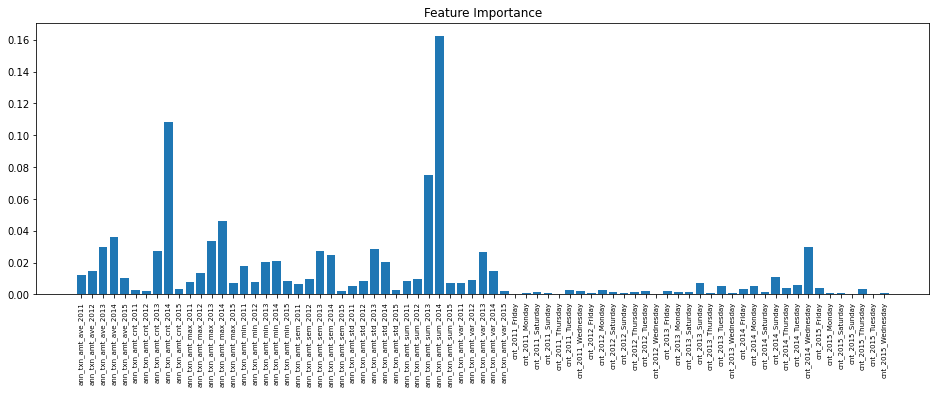

In [181]:
# 5. Plot coeffcient values or feature importance. 
importances = forest.feature_importances_

plt.figure(figsize=(16,5))
plt.bar(range(X_annual.shape[1]), importances)
plt.title("Feature Importance")
plt.xticks(range(X_annual.shape[1]), X_annual.columns, rotation=90,size=7)
plt.show()

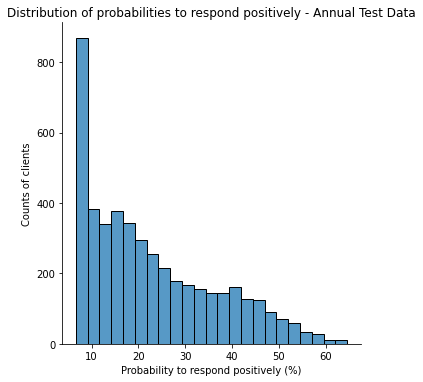

In [182]:
# 6. Plot probability distribution for test set
y_test_proba = forest.predict_proba(X_test_annual)
sns.displot(data = y_test_proba[:,1], x = 100*y_test_proba[:,1])
plt.title('Distribution of probabilities to respond positively - Annual Test Data')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.show()

In [183]:
# 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

Test Accuracy: 0.8764705882352941


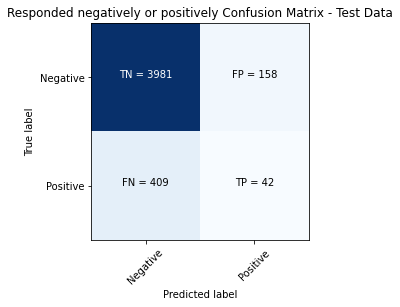



 Train Accuracy: 0.8549540347293156


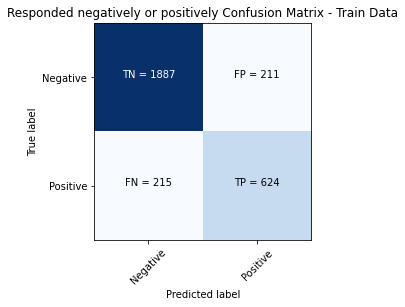

In [185]:
# Confusion matrix - Test Data

y_test_predicted = forest.predict (X_test_annual)
cm = confusion_matrix(y_test_annual, y_test_predicted)
print ('Test Accuracy:',accuracy_score(y_test_annual, y_test_predicted))
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
plt.show()

# Confusion matrix - Train Data
y_train_proba = forest.predict_proba(X_train_annual)
y_train_predicted = [1 if x >= 0.40 else 0 for x in y_train_proba[:,1]] # lower treshhold for classification
print ('\n\n Train Accuracy:',accuracy_score(y_train_annual, y_train_predicted))
cm = confusion_matrix(y_train_annual, y_train_predicted)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

plt.show() 

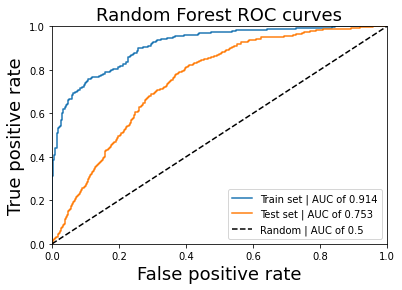

In [186]:
# ROC curves - Train set
scores_train = forest.predict_proba(X_train_annual)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train_annual, scores_train)
auc_train = auc(fpr_train, tpr_train)

# ROC curves - Test Data
scores_test = forest.predict_proba(X_test_annual)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test_annual, scores_test)
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Random Forest ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

In [65]:
# precision/recall
print(classification_report(y_test_annual, y_test_predicted, target_names = ['Negative(0)', 'Positive(1)']))

              precision    recall  f1-score   support

 Negative(0)       0.91      0.96      0.93      4139
 Positive(1)       0.21      0.09      0.13       451

    accuracy                           0.88      4590
   macro avg       0.56      0.53      0.53      4590
weighted avg       0.84      0.88      0.85      4590



In [66]:
# 8. Plot decision boundary for top 2 features.

min_list = X_train_annual.min(axis=0) 
max_list = X_train_annual.max(axis=0)

# top feature index
top_feature1_index = list(importances).index(np.sort(importances)[-1])
top_feature2_index = list(importances).index(np.sort(importances)[-2])

# top feature
top_feature1 = X_annual.columns[top_feature1_index]
top_feature2 = X_annual.columns[top_feature2_index]

# min/max 
top_feature1_min= min_list[top_feature1_index]
top_feature1_max= max_list[top_feature1_index]
top_feature2_min= min_list[top_feature2_index]
top_feature2_max= max_list[top_feature2_index]

print ('1st top feature {}, min={}, max={}'.format(top_feature1,top_feature1_min,top_feature1_max))
print ('2nd top feature {}, min={}, max={}'.format(top_feature2,top_feature2_min,top_feature2_max))

1st top feature ann_txn_amt_sum_2014, min=-1.8280677621886374, max=3.414767789738315
2nd top feature ann_txn_amt_cnt_2014, min=-2.1595762332329147, max=3.34401341842013


In [69]:
xx, yy = np.mgrid[-2.1:4.1, -3.1:4.1]
grid = np.c_[xx.ravel(), yy.ravel()]
print ('grid dimenshion:',grid.shape) # Confirm grid shape  
# calculates the median of every column  
median_inputs = np.ones((grid.shape[0], X_train_annual.shape[1])) * np.median(X_train_annual, axis=0) 

# replace the column of top 2 features with the values of the grid
median_inputs[:,top_feature1_index] = grid[:,0]
median_inputs[:,top_feature2_index] = grid[:,1]
 
# compute probability of respende positively
probs = forest.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

grid dimenshion: (56, 2)


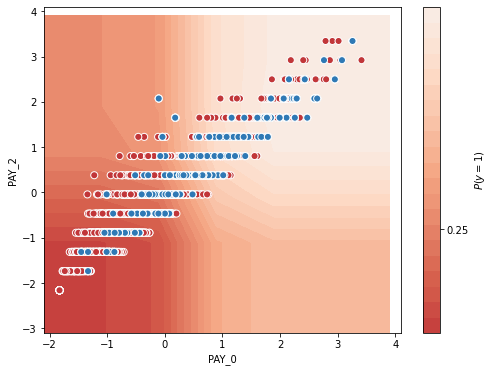

In [71]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_annual[50:,top_feature1_index], X_train_annual[50:,top_feature2_index], c=y_train_annual[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
# plt.annotate('Node #6 \n P(default) = 69.9%', xy=(5,1), xycoords='data',horizontalalignment= 'center', fontsize = 14)
# plt.annotate('Node #2 \n P = 15.0%', xy=(-0.5,0.5), xycoords='data',horizontalalignment= 'center', fontsize = 14)
# plt.annotate('Node #5 \n P = 43.1%', xy=(-0.5,6.0), xycoords='data',horizontalalignment= 'center', fontsize = 14)

ax.set(aspect="auto",
       xlim=(-2.1, 4.1), ylim=(-3.1, 4.1),
       xlabel="PAY_0", ylabel="PAY_2")
plt.show()

### Monthly Features

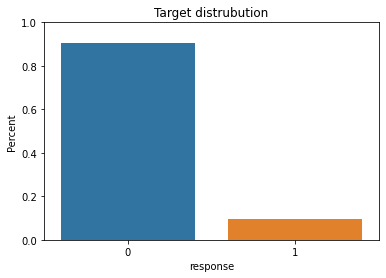

In [72]:
# Data overview (unbalance)
 
sns.barplot(x="response", y="response", data=monthly_features_outputs, estimator=lambda x: len(x) / len(monthly_features_outputs))
plt.ylabel("Percent")
plt.title('Target distrubution')
plt.ylim(0,1)
plt.show()

In [73]:
# 1. Separate the inputs X and the output y  
X_monthly = monthly_features_outputs.drop(['response','CLNT_NO','ME_DT'],1)
y_monthly = monthly_features_outputs.response

unique_elements, counts_elements = np.unique(y_monthly, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1]
 [293139  30409]]


In [74]:
# 2. Split the data in train and test set. 
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = train_test_split(X_monthly, y_monthly, test_size=2/3, random_state=1147)

unique_elements, counts_elements = np.unique(y_train_monthly, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[    0     1]
 [97742 10107]]


In [75]:
# Random over sample minority class on training data
ros = RandomOverSampler(sampling_strategy=0.4,random_state=1147)
X_train_monthly, y_train_monthly = ros.fit_sample(X_train_monthly, y_train_monthly)

unique_elements, counts_elements = np.unique(y_train_monthly, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[    0     1]
 [97742 39096]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#### 1. Logistic Regression with L1 regularization

In [76]:
# 3. Pre-process data (standardized)
scaler = StandardScaler()
X_train_monthly = scaler.fit_transform(X_train_monthly)
X_test_monthly = scaler.transform(X_test_monthly)

In [77]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
lr = LogisticRegression(penalty ='l1', solver = 'liblinear', random_state=1147)

# Gridsearch best hyperparameters using mereic 'roc_auc'
grid = GridSearchCV(lr, {'C':[0.01, 0.1, 1, 10, 100,1000]}, scoring='f1', cv=10, n_jobs=-1)
grid.fit(X_train_monthly , y_train_monthly )
best_hyper = grid.best_params_
print ("Best f1: {}".format(grid.best_score_))      
print('The best parameter:', best_hyper)

# fit model on the training dataset
lr = LogisticRegression(C=best_hyper['C'], penalty ='l1', solver = 'liblinear', random_state=1147)
lr.fit(X_train_monthly , y_train_monthly )

Best f1: 0.08232739803655137
The best parameter: {'C': 10}


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=1147, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

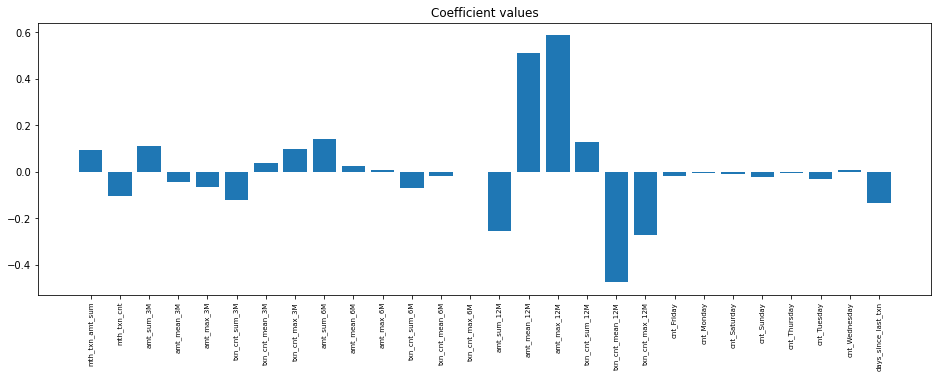

In [78]:
# 5. Plot coeffcient values or feature importance.
coeffcient = lr.coef_

plt.figure(figsize=(16,5))
plt.bar(range(X_monthly.shape[1]), coeffcient[0])
plt.title("Coefficient values")
plt.xticks(range(X_monthly.shape[1]), X_monthly.columns, rotation=90,size=7)
plt.show()

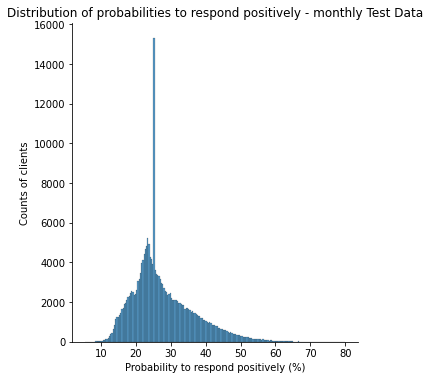

In [79]:
# 6. Plot probability distribution for test set
y_test_proba = lr.predict_proba(X_test_monthly)
sns.displot(data = y_test_proba[:,1], x = 100 * y_test_proba[:,1])
plt.title('Distribution of probabilities to respond positively - monthly Test Data')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.show()

In [80]:
# 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

Test Accuracy: 0.8109819702455737


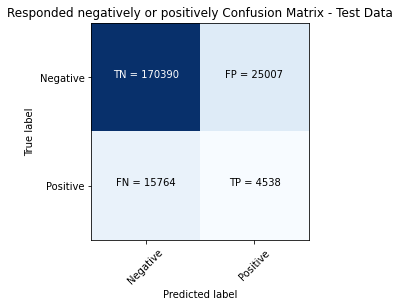



 Train Accuracy: 0.7134567883190341


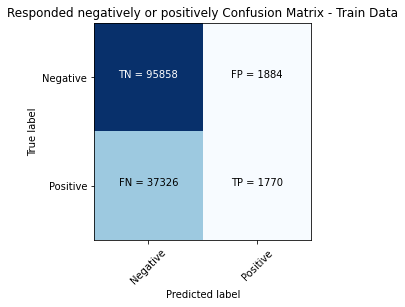

In [81]:
# Confusion matrix - Test Data

# y_test_predicted = lr.predict (X_test_monthly)
# cm = confusion_matrix(y_test_monthly, y_test_predicted)

y_test_proba = lr.predict_proba(X_test_monthly)
y_test_predicted = [1 if x >= 0.38 else 0 for x in y_test_proba[:,1]] # lower treshhold for classification
print ('Test Accuracy:',accuracy_score(y_test_monthly, y_test_predicted))
cm = confusion_matrix(y_test_monthly, y_test_predicted)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
plt.show()

# Confusion matrix - Train Data
y_train_proba = lr.predict_proba(X_train_monthly)
y_train_predicted = [1 if x >= 0.50 else 0 for x in y_train_proba[:,1]] # lower treshhold for classification
print ('\n\n Train Accuracy:',accuracy_score(y_train_monthly, y_train_predicted))
cm = confusion_matrix(y_train_monthly, y_train_predicted)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

plt.show()

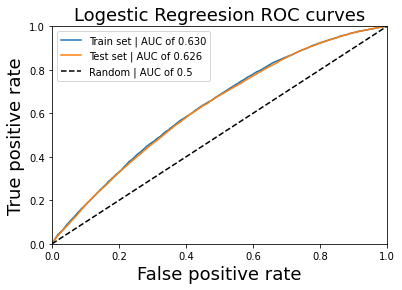

In [168]:
# ROC curves - Train set
scores_train = lr.predict_proba(X_train_monthly)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
auc_train = auc(fpr_train, tpr_train)

# ROC curves - Test Data
scores_test = lr.predict_proba(X_test_monthly)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Logestic Regreesion ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

In [83]:
# precision/recall
print(classification_report(y_test_monthly, y_test_predicted, target_names = ['Negative(0)', 'Positive(1)']))

              precision    recall  f1-score   support

 Negative(0)       0.92      0.87      0.89    195397
 Positive(1)       0.15      0.22      0.18     20302

    accuracy                           0.81    215699
   macro avg       0.53      0.55      0.54    215699
weighted avg       0.84      0.81      0.83    215699



In [84]:
# 8. Plot decision boundary for top 2 features.

min_list = X_train_monthly.min(axis=0) 
max_list = X_train_monthly.max(axis=0)

# top feature index
top_feature1_index = list(coeffcient[0]).index(np.sort(coeffcient[0])[-1])
top_feature2_index = list(coeffcient[0]).index(np.sort(coeffcient[0])[-2])

# top feature
top_feature1 = X_monthly.columns[top_feature1_index]
top_feature2 = X_monthly.columns[top_feature2_index]

# min/max 
top_feature1_min= min_list[top_feature1_index]
top_feature1_max= max_list[top_feature1_index]
top_feature2_min= min_list[top_feature2_index]
top_feature2_max= max_list[top_feature2_index]

print ('1st top feature {}, min={}, max={}'.format(top_feature1,top_feature1_min,top_feature1_max))
print ('2nd top feature {}, min={}, max={}'.format(top_feature2,top_feature2_min,top_feature2_max))

1st top feature amt_max_12M, min=-1.1976631579969659, max=4.641693736999415
2nd top feature amt_mean_12M, min=-1.1976631579973707, max=4.641693737000946


In [87]:
xx, yy = np.mgrid[-2.1:5.1, -2.1:5.1]
grid = np.c_[xx.ravel(), yy.ravel()]
print ('grid dimenshion:',grid.shape) # Confirm grid shape  

grid dimenshion: (64, 2)


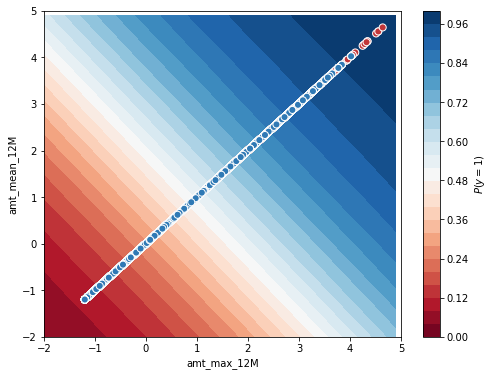

In [89]:
# calculates the median of every column  
median_inputs = np.ones((grid.shape[0], X_train_monthly.shape[1])) * np.median(X_train_monthly, axis=0) 

# replace the column of top 2 features with the values of the grid
median_inputs[:,top_feature1_index] = grid[:,0]
median_inputs[:,top_feature2_index] = grid[:,1]
 
# compute probability of respende positively
probs = lr.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

# plot decision boundary
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
# ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_monthly[50:,top_feature1_index], X_train_monthly[50:, top_feature2_index], c=y_train_monthly[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="auto",
       xlim=(-2, 5), ylim=(-2, 5),
       xlabel=str(top_feature1), ylabel=str(top_feature2))

plt.show()

#### 2. Decision Tree

In [136]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
tree = DecisionTreeClassifier(criterion = 'gini', random_state=1147, max_depth = 10, ccp_alpha = 0.002)

# Gridsearch best hyperparameters using mereic 'roc_auc'
grid = GridSearchCV(tree, {'min_samples_split':[1,20,50,100,500]}, scoring='f1', cv=10, n_jobs=-1)
grid.fit(X_train_monthly, y_train_monthly)
best_hyper = grid.best_params_
print ("Best f1: {}".format(grid.best_score_))      
print('The best parameter:', best_hyper)

# fit model on the training dataset
tree = DecisionTreeClassifier(min_samples_split=best_hyper['min_samples_split'],
                              criterion = 'gini', random_state=1147, max_depth = 10,ccp_alpha = 0.002)
tree.fit(X_train_monthly, y_train_monthly)

Best f1: 0.0
The best parameter: {'min_samples_split': 20}


DecisionTreeClassifier(ccp_alpha=0.002, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1147, splitter='best')

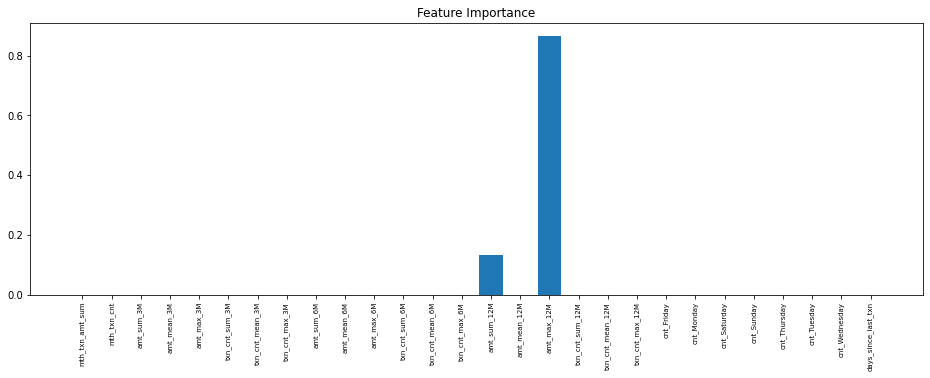

In [137]:
# 5. Plot coeffcient values or feature importance. 
importances = tree.feature_importances_

plt.figure(figsize=(16,5))
plt.bar(range(X_monthly.shape[1]), importances)
plt.title("Feature Importance")
plt.xticks(range(X_monthly.shape[1]), X_monthly.columns, rotation=90,size=7)
plt.show()

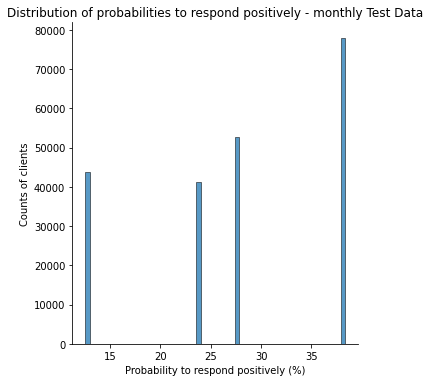

In [138]:
# 6. Plot probability distribution for test set
y_test_proba = tree.predict_proba(X_test_monthly)
sns.displot(data = y_test_proba[:,1], x = 100*y_test_proba[:,1])
plt.title('Distribution of probabilities to respond positively - monthly Test Data')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.show()

In [139]:
# How many different probabilities of respond positively are there and how many clients in each?
unique_elements, counts_elements = np.unique(y_test_proba[:,1], return_counts=True)
print("Frequency of unique values of the said array:")
print(unique_elements)
print(counts_elements)

Frequency of unique values of the said array:
[0.12548842 0.23976772 0.27636176 0.3836341 ]
[43699 41251 52764 77985]


In [140]:
# 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

Test Accuracy: 0.9058780986467253


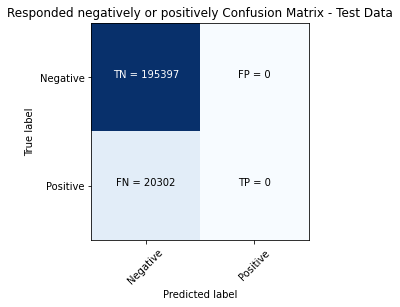



 Train Accuracy: 0.7142898902351686


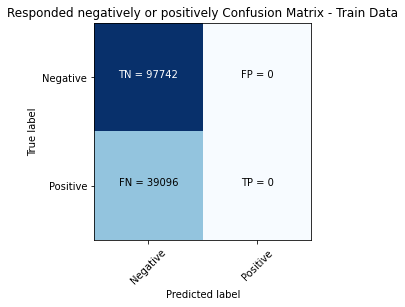

In [141]:
# Confusion matrix - Test Data

y_test_predicted = tree.predict (X_test_monthly)
cm = confusion_matrix(y_test_monthly, y_test_predicted)
print ('Test Accuracy:',accuracy_score(y_test_monthly, y_test_predicted))
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
plt.show()

# Confusion matrix - Train Data

y_train_proba = tree.predict_proba(X_train_monthly)
y_train_predicted = [1 if x >= 0.40 else 0 for x in y_train_proba[:,1]] # lower treshhold for classification
print ('\n\n Train Accuracy:',accuracy_score(y_train_monthly, y_train_predicted))
cm = confusion_matrix(y_train_monthly, y_train_predicted)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

plt.show() 

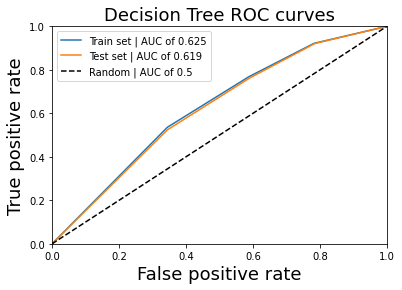

In [142]:
# ROC curves - Train set
scores_train = tree.predict_proba(X_train_monthly)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
auc_train = auc(fpr_train, tpr_train)

# ROC curves - Test Data
scores_test = tree.predict_proba(X_test_monthly)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Decision Tree ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

In [143]:
# precision/recall
print(classification_report(y_test_monthly, y_test_predicted, target_names = ['Negative(0)', 'Positive(1)']))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Negative(0)       0.91      1.00      0.95    195397
 Positive(1)       0.00      0.00      0.00     20302

    accuracy                           0.91    215699
   macro avg       0.45      0.50      0.48    215699
weighted avg       0.82      0.91      0.86    215699



In [144]:
# 8. Plot decision boundary for top 2 features.

min_list = X_train_monthly.min(axis=0) 
max_list = X_train_monthly.max(axis=0)

# top feature index
top_feature1_index = list(importances).index(np.sort(importances)[-1])
top_feature2_index = list(importances).index(np.sort(importances)[-2])

# top feature
top_feature1 = X_monthly.columns[top_feature1_index]
top_feature2 = X_monthly.columns[top_feature2_index]

# min/max 
top_feature1_min= min_list[top_feature1_index]
top_feature1_max= max_list[top_feature1_index]
top_feature2_min= min_list[top_feature2_index]
top_feature2_max= max_list[top_feature2_index]

print ('1st top feature {}, min={}, max={}'.format(top_feature1,top_feature1_min,top_feature1_max))
print ('2nd top feature {}, min={}, max={}'.format(top_feature2,top_feature2_min,top_feature2_max))

1st top feature amt_max_12M, min=-1.1976631579969659, max=4.641693736999415
2nd top feature amt_sum_12M, min=-1.3238847488617995, max=5.404820697991129


In [145]:
xx, yy = np.mgrid[-2.1:5.1, -2.1:6.1]
grid = np.c_[xx.ravel(), yy.ravel()]
print ('grid dimenshion:',grid.shape) # Confirm grid shape  
# calculates the median of every column  
median_inputs = np.ones((grid.shape[0], X_train_monthly.shape[1])) * np.median(X_train_monthly, axis=0) 

# replace the column of top 2 features with the values of the grid
median_inputs[:,top_feature1_index] = grid[:,0]
median_inputs[:,top_feature2_index] = grid[:,1]
 
# compute probability of respende positively
probs = tree.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

grid dimenshion: (72, 2)


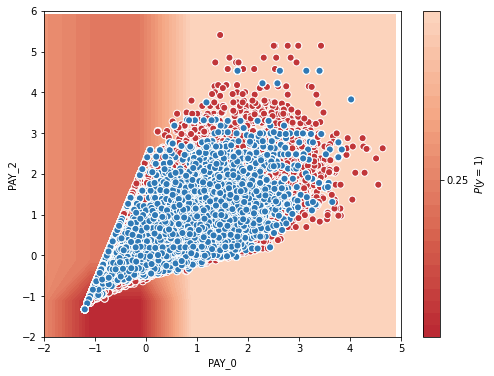

In [146]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_monthly[50:,top_feature1_index], X_train_monthly[50:,top_feature2_index], c=y_train_monthly[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
# plt.annotate('Node #6 \n P(default) = 69.9%', xy=(5,1), xycoords='data',horizontalalignment= 'center', fontsize = 14)
# plt.annotate('Node #2 \n P = 15.0%', xy=(-0.5,0.5), xycoords='data',horizontalalignment= 'center', fontsize = 14)
# plt.annotate('Node #5 \n P = 43.1%', xy=(-0.5,6.0), xycoords='data',horizontalalignment= 'center', fontsize = 14)

ax.set(aspect="auto",
       xlim=(-2, 5), ylim=(-2, 6),
       xlabel="PAY_0", ylabel="PAY_2")
plt.show()

#### 3. Random Forests


In [152]:
# 4. Fit the training dataset and optimize the hyperparameters of the method
forest = RandomForestClassifier(n_estimators = 200, criterion = 'gini',random_state=1147, max_depth = 10, ccp_alpha = 0.002)

# Gridsearch best hyperparameters using mereic 'roc_auc'
grid = GridSearchCV(forest, {'min_samples_split':[1,20,50,100,500]}, scoring='f1', cv=10, n_jobs=-1)
grid.fit(X_train_monthly, y_train_monthly)
best_hyper = grid.best_params_
print ("Best f1: {}".format(grid.best_score_))      
print('The best parameter:', best_hyper)

# fit model on the training dataset
forest = RandomForestClassifier(min_samples_split=best_hyper['min_samples_split'],
                                n_estimators = 200, criterion = 'gini',random_state=1147, max_depth = 10, ccp_alpha = 0.002)

forest.fit(X_train_monthly, y_train_monthly)

Best f1: 0.0
The best parameter: {'min_samples_split': 20}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.002, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1147,
                       verbose=0, warm_start=False)

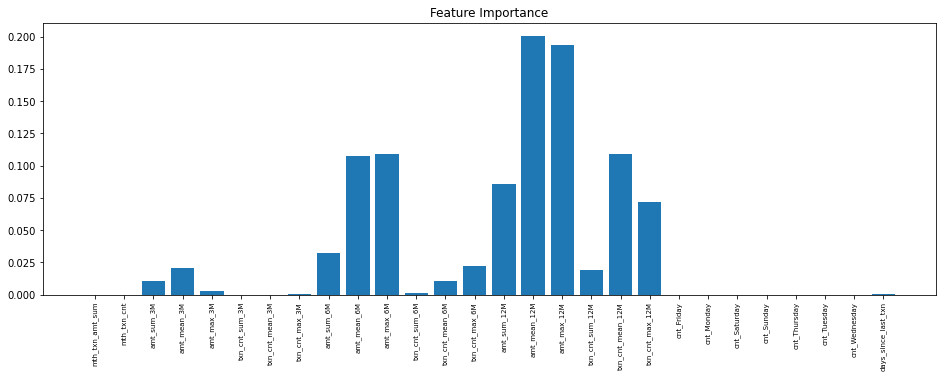

In [156]:
# 5. Plot coeffcient values or feature importance. 
importances = forest.feature_importances_

plt.figure(figsize=(16,5))
plt.bar(range(X_monthly.shape[1]), importances)
plt.title("Feature Importance")
plt.xticks(range(X_monthly.shape[1]), X_monthly.columns, rotation=90,size=7)
plt.show()

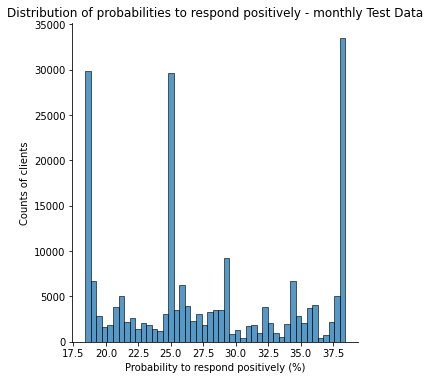

In [157]:
# 6. Plot probability distribution for test set
y_test_proba = forest.predict_proba(X_test_monthly)
sns.displot(data = y_test_proba[:,1], x = 100*y_test_proba[:,1])
plt.title('Distribution of probabilities to respond positively - monthly Test Data')
plt.xlabel('Probability to respond positively (%)')
plt.ylabel('Counts of clients')
plt.show()

In [158]:
# 7. Plot confusion matrix and ROC curves of train/test set. Calculate precision/recall.

Test Accuracy: 0.9058780986467253


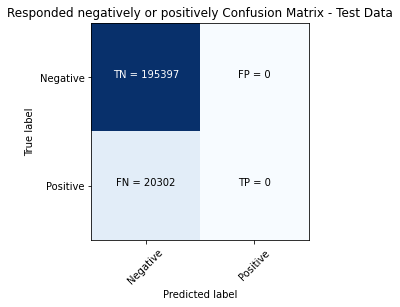



 Train Accuracy: 0.7142898902351686


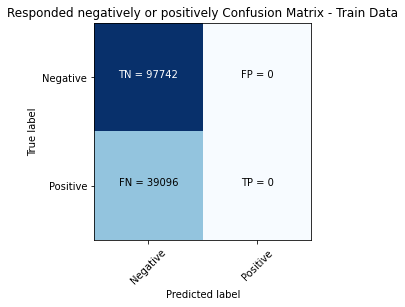

In [167]:
# Confusion matrix - Test Data

y_test_predicted = forest.predict (X_test_monthly)
cm = confusion_matrix(y_test_monthly, y_test_predicted)
print ('Test Accuracy:',accuracy_score(y_test_monthly, y_test_predicted))
 
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
plt.show()

# Confusion matrix - Train Data

y_train_proba = forest.predict_proba(X_train_monthly)
y_train_predicted = [1 if x >= 0.40 else 0 for x in y_train_proba[:,1]] # lower treshhold for classification
print ('\n\n Train Accuracy:',accuracy_score(y_train_monthly, y_train_predicted))
cm = confusion_matrix(y_train_monthly, y_train_predicted)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Negative','Positive']
s = [['TN','FP'], ['FN', 'TP']]
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.title('Responded negatively or positively Confusion Matrix - Train Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

plt.show() 

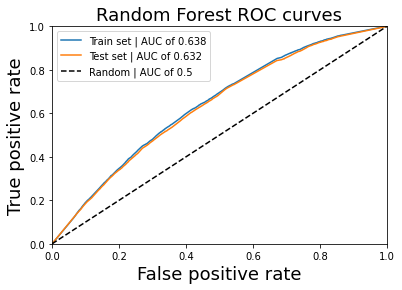

In [169]:
# ROC curves - Train set
scores_train = forest.predict_proba(X_train_monthly)[:, 1]
fpr_train, tpr_train, _ = roc_curve(y_train_monthly, scores_train)
auc_train = auc(fpr_train, tpr_train)

# ROC curves - Test Data
scores_test = forest.predict_proba(X_test_monthly)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test_monthly, scores_test)
auc_test  = auc(fpr_test, tpr_test)

# Plotting
plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train));
plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test));
plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5');
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Random Forest ROC curves', fontsize = 18)
plt.ylabel('True positive rate', fontsize = 18)
plt.xlabel('False positive rate', fontsize = 18)
plt.legend()
plt.show()

In [161]:
# precision/recall
print(classification_report(y_test_monthly, y_test_predicted, target_names = ['Negative(0)', 'Positive(1)']))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Negative(0)       0.91      1.00      0.95    195397
 Positive(1)       0.00      0.00      0.00     20302

    accuracy                           0.91    215699
   macro avg       0.45      0.50      0.48    215699
weighted avg       0.82      0.91      0.86    215699



In [162]:
# 8. Plot decision boundary for top 2 features.

min_list = X_train_monthly.min(axis=0) 
max_list = X_train_monthly.max(axis=0)

# top feature index
top_feature1_index = list(importances).index(np.sort(importances)[-1])
top_feature2_index = list(importances).index(np.sort(importances)[-2])

# top feature
top_feature1 = X_monthly.columns[top_feature1_index]
top_feature2 = X_monthly.columns[top_feature2_index]

# min/max 
top_feature1_min= min_list[top_feature1_index]
top_feature1_max= max_list[top_feature1_index]
top_feature2_min= min_list[top_feature2_index]
top_feature2_max= max_list[top_feature2_index]

print ('1st top feature {}, min={}, max={}'.format(top_feature1,top_feature1_min,top_feature1_max))
print ('2nd top feature {}, min={}, max={}'.format(top_feature2,top_feature2_min,top_feature2_max))

1st top feature amt_mean_12M, min=-1.1976631579973707, max=4.641693737000946
2nd top feature amt_max_12M, min=-1.1976631579969659, max=4.641693736999415


In [165]:
xx, yy = np.mgrid[-2.1:5.1, -3.1:5.1]
grid = np.c_[xx.ravel(), yy.ravel()]
print ('grid dimenshion:',grid.shape) # Confirm grid shape  
# calculates the median of every column  
median_inputs = np.ones((grid.shape[0], X_train_monthly.shape[1])) * np.median(X_train_monthly, axis=0) 

# replace the column of top 2 features with the values of the grid
median_inputs[:,top_feature1_index] = grid[:,0]
median_inputs[:,top_feature2_index] = grid[:,1]
 
# compute probability of respende positively
probs = forest.predict_proba(median_inputs)[:, 1].reshape(xx.shape)

grid dimenshion: (72, 2)


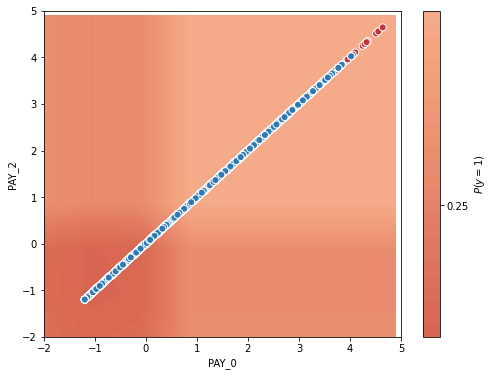

In [166]:
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_train_monthly[50:,top_feature1_index], X_train_monthly[50:,top_feature2_index], c=y_train_monthly[50:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)
# plt.annotate('Node #6 \n P(default) = 69.9%', xy=(5,1), xycoords='data',horizontalalignment= 'center', fontsize = 14)
# plt.annotate('Node #2 \n P = 15.0%', xy=(-0.5,0.5), xycoords='data',horizontalalignment= 'center', fontsize = 14)
# plt.annotate('Node #5 \n P = 43.1%', xy=(-0.5,6.0), xycoords='data',horizontalalignment= 'center', fontsize = 14)

ax.set(aspect="auto",
       xlim=(-2, 5), ylim=(-2, 5),
       xlabel="PAY_0", ylabel="PAY_2")
plt.show()

## 1.3 Comparison of methods
    Compare the two feature engineering (annual and monthly) and the three modeling approaches (L1 log-reg, tree, forests).

    Regression and decision tree algorithm are sensitive to class imbalance. Random forest algorithm also not work well since it is build 
    based on decision trees. Adopted oversample strategy to sample more data from the minority group, for all the combinations of feature 
    engineering and modeling approaches. 

    During the hyperparameter tuning process, select model with highest 'f1' score, which also consider the recall and precision.  


    Coeffcient values or feature importance. For both Annual and Monthly features:
    ✓ L1 log-reg: low regularization strength, which is decided by the hyperparameter tunning process. 
    ✓ Tree: less features are selected since the decision tree model is easily to be overfitting.  
    ✓ Forests: only few features have zero importance. Random forests build not only one tree, more features have been used when 
    there's more trees. 

    ROC curves of train/test set:
    For annual features, random forest model has the highest testing AUC score but high traing AUC, the model might overfitting.
    Logestic regression also havs high testing AUC score, and it's close to traing AUC. 
    For monthly features, all three models have low AUC scores, indicates the lack of ability to classify two groups. 
 

|Feature   | Model  | precision | recall |Test Accuracy| Test set Probability distribution| Testing AUC|Training AUC|
| ------------- | ------------- | ------------- |  --- |----|--|---|----|
| Annual | L1 log-reg|0.22|0.36 |0.8126|lot of clients has probability to respond positively between 50% - 100% |0.730|0.840
|        | Tree|0.20  |    0.33 | 0.8009|some clients has probability to respond positively between 55% - 80% |0.694|0.803
|        | Forests|0.21| 0.09| 0.8765|some clients has probability to respond positively between 50% - 65% |0.753|0.914
| Monthly| L1 log-reg|0.15   |   0.22  |0.8110|some clients has probability to respond positively between 50% - 70% | 0.626|0.63
|        | Tree|0.00 |    0.00  | 0.9059| no client has probability to respond positively > 40% |0.619|0.625
|        | Forests| 0.00   |   0.00| 0.9059| no client has probability to respond positively > 40% |0.632|0.638

    Decision boundary for top 2 features, for all the combinations:
    The dicision bounday of top 2 features does not classify two groups well. Maybe only using 2 top features is not enough to generalize 
    the difference between clients who respond positively and negatively.  

    Which combination approach do you select as the best to deploy in a production environment and why? 
    
    This question relate to promotional campaign, compare to miss  client respond positively, promote to client who respond negatively 
    is more accepted. The goal is to minimize FN. Recall of 1 could achieved by estimating all data as positively responded clients, but 
    the cost would be high in this way. 
    
    I would choose Annual features and Logestic regression, which have highes recall, and the accuacy is still pretty good.
 